In [11]:
!pip install wandb

## Simple NN for CV

This project is for learning some basics of computer vision by building a small neural network. It is without activation functions and convolution

### Reading and visualizing image dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMG_H = 224
IMG_W = 224
IMG_C = 3
CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [3]:
# all inside tf
def read_and_decode_image(filename, resize_dims):
    #read the raw file
    image = tf.io.read_file(filename)
    #decode image data
    image = tf.image.decode_jpeg(image, channels=IMG_C)
    #convert pixel values to float in [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    #resize image
    image = tf.image.resize(image, resize_dims)
    return image

In [4]:
# dataset is in form of cvs file(metadata) with details about each image
def parse_csvline(csv_line):
  # record_defaults specify the data types for each column
  record_defaults = ["", ""]
  filename, label_string = tf.io.decode_csv(csv_line, record_defaults)

  #load image
  img = read_and_decode_image(filename, [IMG_H, IMG_W])

  #convert label string to integer based on CLASS_NAMES index eg. "daisy" --> 0
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [5]:
# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
  )

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
print(train_dataset.take)
# print(len(eval_dataset))

<bound method DatasetV2.take of <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>>


In [7]:
for image, label in train_dataset.take(1):
  print("Image batch shape: ", image.shape)
  print("Label batch shape: ", label.shape)
  print("Labels: ",label.numpy())

Image batch shape:  (16, 224, 224, 3)
Label batch shape:  (16,)
Labels:  [0 1 1 1 0 2 1 0 4 3 0 3 1 4 4 1]


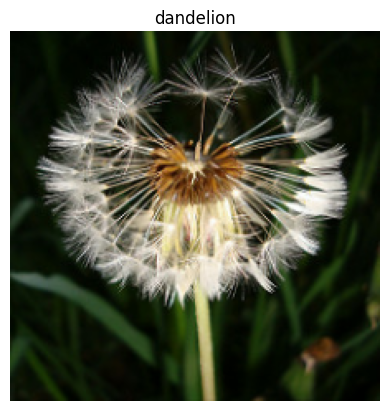

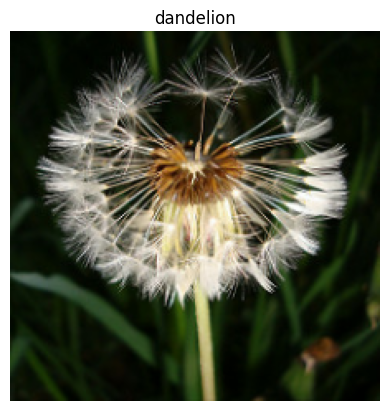

In [8]:
for images, label in train_dataset.take(2):
  #take first image from batch
  first_img = image[3]
  first_label =  label[3]

  #convert tensor to numpy array
  plt.imshow(first_img.numpy())
  plt.title(CLASS_NAMES[first_label.numpy()])
  plt.axis("off")
  plt.show()

### building linear model

Main purpose is to find out how much best accuracy can we get from a shallow linear classification model.  

Operation to follow:
Flattening --> dense fully connected --> softmax

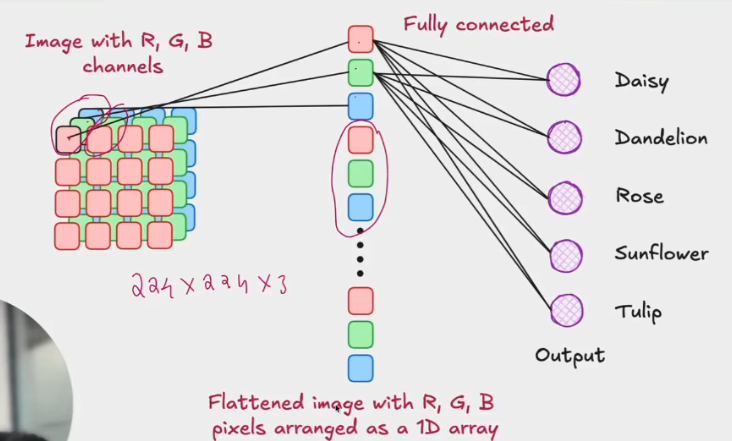  

*Note*: Here we are converting the ouput to probabilistic distribution using softmax activation. We are not using the activation function inside the model





In [9]:
from tensorflow import keras  #keras makes use of tf easy

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_H, IMG_W, IMG_C)), # entire image represented in 1D
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
EPOCH = 10

logs = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=EPOCH,
)

Epoch 1/10
    206/Unknown 185s 892ms/step - accuracy: 0.3224 - loss: 22.8764

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


207/207 ━━━━━━━━━━━━━━━━━━━━ 203s 973ms/step - accuracy: 0.3228 - loss: 22.7983 - val_accuracy: 0.4405 - val_loss: 5.8362
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 141s 679ms/step - accuracy: 0.4071 - loss: 10.9984 - val_accuracy: 0.3622 - val_loss: 15.6835
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 171s 822ms/step - accuracy: 0.4314 - loss: 13.2023 - val_accuracy: 0.4189 - val_loss: 13.9856
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 168s 812ms/step - accuracy: 0.4568 - loss: 13.8537 - val_accuracy: 0.4486 - val_loss: 10.4599
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 157s 755ms/step - accuracy: 0.5027 - loss: 10.1368 - val_accuracy: 0.4297 - val_loss: 17.8449
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 128s 613ms/step - accuracy: 0.5226 - loss: 9.2278 - val_accuracy: 0.4027 - val_loss: 14.5043
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 170s 821ms/step - accuracy: 0.5438 - loss: 9.0230 - val_accuracy: 0.4054 - val_loss: 11.7328
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 171s 821ms/step - accuracy: 0.5737 -

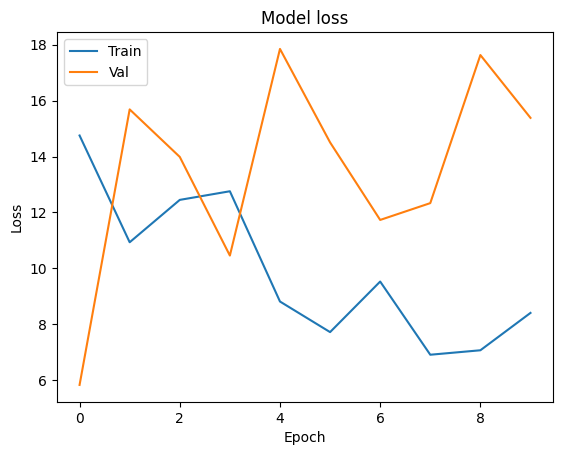

In [17]:
import matplotlib.pyplot as plt

plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

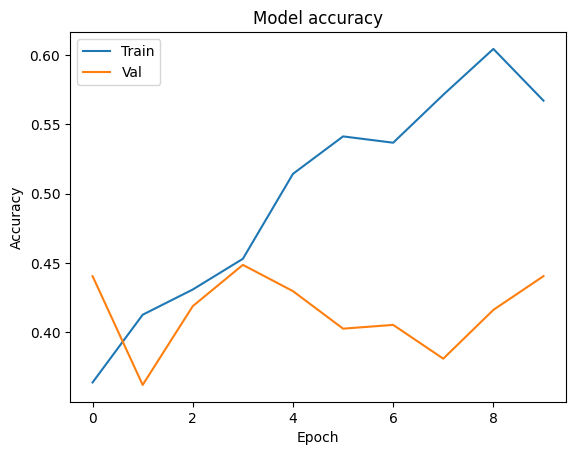

In [18]:
plt.plot(logs.history['accuracy'])
plt.plot(logs.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

### Observations

-> Accuracy plot becomes choppy which indicates that our batch size and learning rate can be improved. (hyperparameter tuning)  

-> In last epoch, training loss dec whereas val loss inc which shows signs of overfitting.



### New model with 2 hidden layers + activation function

Activation function helps introduce non-linearity in layers. Without it, all layers would behave in same manner.


In [6]:
from tensorflow import keras  #keras makes use of tf easy

tf.device('/device:GPU:0')

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_H, IMG_W, IMG_C)), # entire image represented in 1D
    keras.layers.Dense(128, activation='relu' ),
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
EPOCH = 10

logs = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=EPOCH,
)

Epoch 1/10
    207/Unknown 39s 181ms/step - accuracy: 0.3141 - loss: 19.8917

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


207/207 ━━━━━━━━━━━━━━━━━━━━ 43s 201ms/step - accuracy: 0.3142 - loss: 19.8465 - val_accuracy: 0.3297 - val_loss: 6.1421
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.3723 - loss: 3.9579 - val_accuracy: 0.3892 - val_loss: 2.0130
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - accuracy: 0.4335 - loss: 2.0123 - val_accuracy: 0.2405 - val_loss: 1.8720
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 152ms/step - accuracy: 0.2665 - loss: 1.6165 - val_accuracy: 0.2297 - val_loss: 1.8280
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - accuracy: 0.3032 - loss: 1.5357 - val_accuracy: 0.2135 - val_loss: 1.7399
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - accuracy: 0.2930 - loss: 1.5321 - val_accuracy: 0.2703 - val_loss: 1.5846
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - accuracy: 0.3125 - loss: 1.5271 - val_accuracy: 0.2432 - val_loss: 1.5786
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - accuracy: 0.2896 - loss: 1.5401 - va

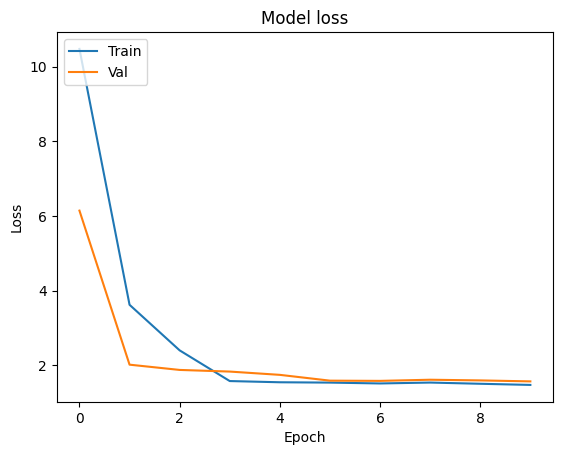

In [8]:
import matplotlib.pyplot as plt

plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

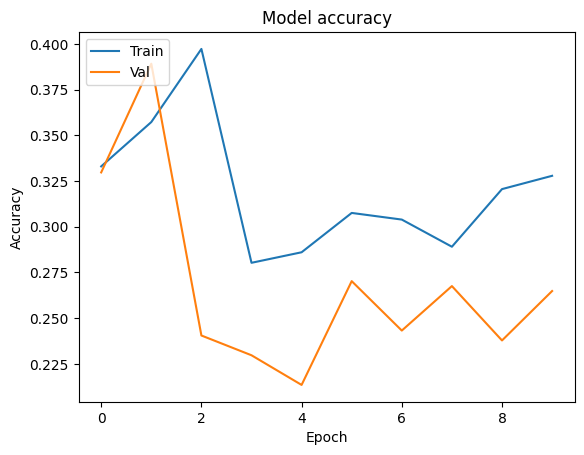

In [9]:
plt.plot(logs.history['accuracy'])
plt.plot(logs.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

An improvement was seen in losses but not in accuracy. This is due to the additional layer. The model becamoe more confident in its prediction, therefore the cross-entrpoy loss decreases as uncertainity decreases.


Now we will try, hyperparameter tuning which includes:  
-> learning rate  
-> image size  
-> batch size

### Hyper-parameter tuning using W&B

In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbMetricsLogger

In [ ]:
!wandb login

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric' : {
        'name': 'val_accuracy',
        'goal': 'maximize'
        },
    'parameters' : {
        'learning_rate': {'values': [1e-3, 1e-4] },
        'batch_size': {'values': [8, 16]},
        'epochs': {'values': [10, 20]},
        'img_size':{'values': [16, 224]},
        'hidden_nodes': {'values': [64, 128]}

    }
}

sweep_id = wandb.sweep(sweep_config, project='DL_journey')

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


Create sweep with ID: 2wceouee
Sweep URL: https://wandb.ai/muskaan-maurya06-none/DL_journey/sweeps/2wceouee


In [ ]:
def train():
  with wandb.init() as run:
    config = wandb.config

    IMG_H = config.img_size
    IMG_W = config.img_size
    IMG_C = 3
    CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

    def read_and_decode_image(filename, resize_dims):
      #read the raw file
      image = tf.io.read_file(filename)
      #decode image data
      image = tf.image.decode_jpeg(image, channels=IMG_C)
      #convert pixel values to float in [0,1]
      image = tf.image.convert_image_dtype(image, tf.float32)
      #resize image
      image = tf.image.resize(image, resize_dims)
      return image

    def parse_csvline(csv_line):
      # record_defaults specify the data types for each column
      record_defaults = ["", ""]
      filename, label_string = tf.io.decode_csv(csv_line, record_defaults)

      #load image
      img = read_and_decode_image(filename, [IMG_H, IMG_W])

      #convert label string to integer based on CLASS_NAMES index eg. "daisy" --> 0
      label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
      return img, label

    train_dataset = (
      tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(tf.data.AUTOTUNE)
    )

    eval_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
        .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    model = keras.Sequential([
      keras.layers.Flatten(input_shape=(IMG_H, IMG_W, IMG_C)), # entire image represented in 1D
      keras.layers.Dense(len(CLASS_NAMES), activation='softmax'),
    ])

    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    EPOCH = 10

    logs = model.fit(
        train_dataset,
        validation_data=eval_dataset,
        epochs=config.epochs,
        callbacks=[WandbMetricsLogger(log_freq=5)]
    )



In [ ]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: whwkv3z4 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 64
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0001


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    412/Unknown 41s 97ms/step - accuracy: 0.3113 - loss: 20.9162

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 45s 108ms/step - accuracy: 0.3114 - loss: 20.9056 - val_accuracy: 0.3595 - val_loss: 24.7215
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.3867 - loss: 19.4236 - val_accuracy: 0.3865 - val_loss: 12.9280
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.4692 - loss: 12.4992 - val_accuracy: 0.4243 - val_loss: 14.1300
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.4855 - loss: 14.5862 - val_accuracy: 0.4459 - val_loss: 17.7199
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.5149 - loss: 14.0898 - val_accuracy: 0.4378 - val_loss: 21.5643
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.5112 - loss: 15.2438 - val_accuracy: 0.4108 - val_loss: 23.6629
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.5007 - loss: 16.3414 - val_accuracy: 0.3081 - val_loss: 62.1557
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.5574 - loss: 17.43

batch/accuracy,▁▁▂▂▂▃▃▃▃▃▅▅▆▅▅▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆██▇▇███▇▇▇
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▇███▇█▇▁▃▄▅▅▄▅▆▄▆▅▅▅▅▆▆▆▆▆▆▆▆▆▇▅▆▅▅▄▅▄▅▆
epoch/accuracy,▁▃▅▅▆▆▆███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▁▄▂▄▅▃▂▃
epoch/val_accuracy,▃▅▆▇▇▆▁██▃
epoch/val_loss,▃▁▁▂▂▃█▃▂▅
batch/accuracy,0.56478


wandb: Agent Starting Run: lms7el97 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.001


Epoch 1/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.3270 - loss: 1.5238 - val_accuracy: 0.4378 - val_loss: 1.3146
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.4273 - loss: 1.3113 - val_accuracy: 0.4622 - val_loss: 1.2671
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.4534 - loss: 1.2564 - val_accuracy: 0.4784 - val_loss: 1.2494
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.4699 - loss: 1.2226 - val_accuracy: 0.4865 - val_loss: 1.2414
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.4879 - loss: 1.1972 - val_accuracy: 0.4919 - val_loss: 1.2379
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.5026 - loss: 1.1764 - val_accuracy: 0.4892 - val_loss: 1.2371
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.5202 - loss: 1.1588 - val_accuracy: 0.4784 - val_loss: 1.2379
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.5289 - loss: 1.1435 - 

batch/accuracy,▁▁▂▄▄▄▄▄▅▄▄▅▅▅▅▅▅▄▅▅▆▅▆▅▆▆▆▆▆▆█▆▆▆▆▆▆▆▆▆
batch/batch_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▇▇▄▄▄▄▄▄▄▂▃▃▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▁▁▁▁▁
epoch/accuracy,▁▄▅▅▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁
epoch/val_accuracy,▁▄▆▇██▆▆▆▆
epoch/val_loss,█▄▂▁▁▁▁▁▂▂
batch/accuracy,0.54897


wandb: Agent Starting Run: 9pwr9snf with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001


Epoch 1/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.3194 - loss: 1.5214 - val_accuracy: 0.4378 - val_loss: 1.3111
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.4308 - loss: 1.3132 - val_accuracy: 0.4622 - val_loss: 1.2676
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4550 - loss: 1.2572 - val_accuracy: 0.4703 - val_loss: 1.2518
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4780 - loss: 1.2227 - val_accuracy: 0.4784 - val_loss: 1.2449
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4937 - loss: 1.1968 - val_accuracy: 0.4811 - val_loss: 1.2421
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4993 - loss: 1.1758 - val_accuracy: 0.4838 - val_loss: 1.2417
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.5093 - loss: 1.1580 - val_accuracy: 0.4757 - val_loss: 1.2428
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.5198 - loss: 1.1426 - 

batch/accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇▇▇██▇▇███████▇███
batch/batch_step,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▅▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁
epoch/val_accuracy,▁▅▆▇██▇▇▆▆
epoch/val_loss,█▄▂▁▁▁▁▁▂▂
batch/accuracy,0.54653


wandb: Agent Starting Run: 6puacn7u with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 224
wandb: 	learning_rate: 0.001


Epoch 1/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.3161 - loss: 23.5061 - val_accuracy: 0.4486 - val_loss: 12.2996
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4118 - loss: 16.6247 - val_accuracy: 0.4784 - val_loss: 11.2192
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4375 - loss: 16.3323 - val_accuracy: 0.4108 - val_loss: 13.8960
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.4728 - loss: 16.0181 - val_accuracy: 0.4297 - val_loss: 18.2695
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.5043 - loss: 14.0215 - val_accuracy: 0.4027 - val_loss: 18.0728
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.5581 - loss: 10.7458 - val_accuracy: 0.3973 - val_loss: 24.1683
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.5284 - loss: 13.4574 - val_accuracy: 0.4081 - val_loss: 23.0381
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.5193 - l

batch/accuracy,▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄█▅▅▅▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅
batch/batch_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▄▄▄▄▃▃▃▄▃▃▃▃▃▃▃▃▃▃▂▂▁▁▂▂▂▃▃▃▃▃▃▅▄▂▂▃▂▂
epoch/accuracy,▁▃▄▄▆▇▆▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▆▂▁▃▆▄▂
epoch/val_accuracy,▆█▄▅▄▃▄▄▁▂
epoch/val_loss,▁▁▂▃▃▄▄▇█▆
batch/accuracy,0.58364


wandb: Agent Starting Run: wz2yl44h with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0001


Epoch 1/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.3150 - loss: 21.4246 - val_accuracy: 0.3865 - val_loss: 17.0732
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4145 - loss: 14.8389 - val_accuracy: 0.4108 - val_loss: 11.0071
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4410 - loss: 16.9346 - val_accuracy: 0.4568 - val_loss: 20.4443
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4783 - loss: 13.3970 - val_accuracy: 0.4108 - val_loss: 22.9410
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.5005 - loss: 15.4942 - val_accuracy: 0.4703 - val_loss: 14.8635
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.5439 - loss: 11.7009 - val_accuracy: 0.4757 - val_loss: 15.7882
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.5155 - loss: 14.7285 - val_accuracy: 0.4243 - val_loss: 18.7699
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.5651 - l

batch/accuracy,▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆█▆▆▆▆▆▆▆▇▇▇▇▅▆▇▆▇
batch/batch_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▃▃▂▂▂▂▂▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃
epoch/accuracy,▁▃▄▆▆▇▇██▇
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▆▂▅▁▂▃▄▇
epoch/val_accuracy,▃▅▇▅██▅▃▅▁
epoch/val_loss,▂▁▂▃▂▂▂▄▄█
batch/accuracy,0.5441


wandb: Agent Starting Run: uvxbd13p with config:
wandb: 	batch_size: 8
wandb: 	epochs: 20
wandb: 	hidden_nodes: 64
wandb: 	img_size: 16
wandb: 	learning_rate: 0.001


Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.3016 - loss: 1.5372 - val_accuracy: 0.4270 - val_loss: 1.3199
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.4248 - loss: 1.3153 - val_accuracy: 0.4595 - val_loss: 1.2717
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.4487 - loss: 1.2598 - val_accuracy: 0.4784 - val_loss: 1.2532
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.4683 - loss: 1.2257 - val_accuracy: 0.4730 - val_loss: 1.2445
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.4847 - loss: 1.2000 - val_accuracy: 0.4757 - val_loss: 1.2404
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.4974 - loss: 1.1791 - val_accuracy: 0.4730 - val_loss: 1.2390
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.5070 - loss: 1.1613 - val_accuracy: 0.4838 - val_loss: 1.2394
Epoch 8/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.5194 - loss: 1.1458 - 

batch/accuracy,▁▄▄▄▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▆▇▇▇▇▇▇▆▇▇▇▇▇█████▇▇█
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▅▅▅▃▄▄▄▃▃▄▃▃▃▃▃▃▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
epoch/accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇█████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▅▇▆▆▆▇█▇▇▇▇▆▆▆▆▇▇▇▇
epoch/val_loss,█▄▂▁▁▁▁▁▁▂▂▂▃▃▄▄▄▅▅▆
batch/accuracy,0.58729


wandb: Agent Starting Run: hn7p7m0m with config:
wandb: 	batch_size: 8
wandb: 	epochs: 20
wandb: 	hidden_nodes: 64
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001


Epoch 1/20
    412/Unknown 20s 48ms/step - accuracy: 0.3094 - loss: 1.5419

wandb: Ctrl + C detected. Stopping sweep.


## Deep NN for CV
Increasing number of hiidden layers can result in overfitting of the model.
To treat this, following techniques are used:  
-> Regularization  
-> Dropout  
-> Early stopping  
-> batch normalization

### Regularization

In [16]:
sweep_config = {
    'method': 'grid',
    'metric' : {
        'name': 'val_accuracy',
        'goal': 'maximize'
        },
    'parameters' : {
        'learning_rate': {'values': [1e-4] },
        'batch_size': {'values': [8]},
        'epochs': {'values': [10]},
        'img_size':{'values': [16]},
        'hidden_nodes': {'values': [128]}

    }
}

sweep_id = wandb.sweep(sweep_config, project='DL_journey')

Create sweep with ID: kfrdcmy2
Sweep URL: https://wandb.ai/muskaan-maurya06-none/DL_journey/sweeps/kfrdcmy2


In [15]:
def train():
  with wandb.init() as run:
    config = wandb.config

    IMG_H = config.img_size
    IMG_W = config.img_size
    IMG_C = 3
    CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

    def read_and_decode_image(filename, resize_dims):
      #read the raw file
      image = tf.io.read_file(filename)
      #decode image data
      image = tf.image.decode_jpeg(image, channels=IMG_C)
      #convert pixel values to float in [0,1]
      image = tf.image.convert_image_dtype(image, tf.float32)
      #resize image
      image = tf.image.resize(image, resize_dims)
      return image

    def parse_csvline(csv_line):
      # record_defaults specify the data types for each column
      record_defaults = ["", ""]
      filename, label_string = tf.io.decode_csv(csv_line, record_defaults)

      #load image
      img = read_and_decode_image(filename, [IMG_H, IMG_W])

      #convert label string to integer based on CLASS_NAMES index eg. "daisy" --> 0
      label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
      return img, label

    train_dataset = (
      tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(tf.data.AUTOTUNE)
    )

    eval_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
        .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    regularizer = keras.regularizers.l1_l2(0, 0.1)

    model = keras.Sequential([
      keras.layers.Flatten(input_shape=(IMG_H, IMG_W, IMG_C)), # entire image represented in 1D
      keras.layers.Dense(config.hidden_nodes, activation='relu', kernel_regularizer=regularizer),
      keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    logs = model.fit(
        train_dataset,
        validation_data=eval_dataset,
        epochs=config.epochs,
        callbacks=[WandbMetricsLogger(log_freq=5)]
    )



In [ ]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: j0aop817 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001


Epoch 1/10
    412/Unknown 35s 82ms/step - accuracy: 0.3165 - loss: 7.8083

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 39s 91ms/step - accuracy: 0.3166 - loss: 7.7886 - val_accuracy: 0.4270 - val_loss: 1.6069
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 32s 77ms/step - accuracy: 0.3503 - loss: 1.6195 - val_accuracy: 0.4108 - val_loss: 1.5812
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.3498 - loss: 1.6001 - val_accuracy: 0.3919 - val_loss: 1.5800
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.3530 - loss: 1.5975 - val_accuracy: 0.3919 - val_loss: 1.5824
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.3471 - loss: 1.5963 - val_accuracy: 0.3892 - val_loss: 1.5810
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.3500 - loss: 1.5946 - val_accuracy: 0.3919 - val_loss: 1.5794
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.3528 - loss: 1.5936 - val_accuracy: 0.3892 - val_loss: 1.5789
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.3504 - loss: 1.5917 - val_accurac

batch/accuracy,▄▄▅▅▁▇▇▆▆▃▄▇▇▆▇▆▇█▇▇▆▄▃▄▆▆▆▆▄▅▇▆▇▇▄▅█▇▇▇
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▅▆▅▅▅▄▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,█▆▃▃▃▃▃▃▂▁
epoch/val_loss,█▂▂▂▂▁▁▁▁▁
batch/accuracy,0.35614


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Result

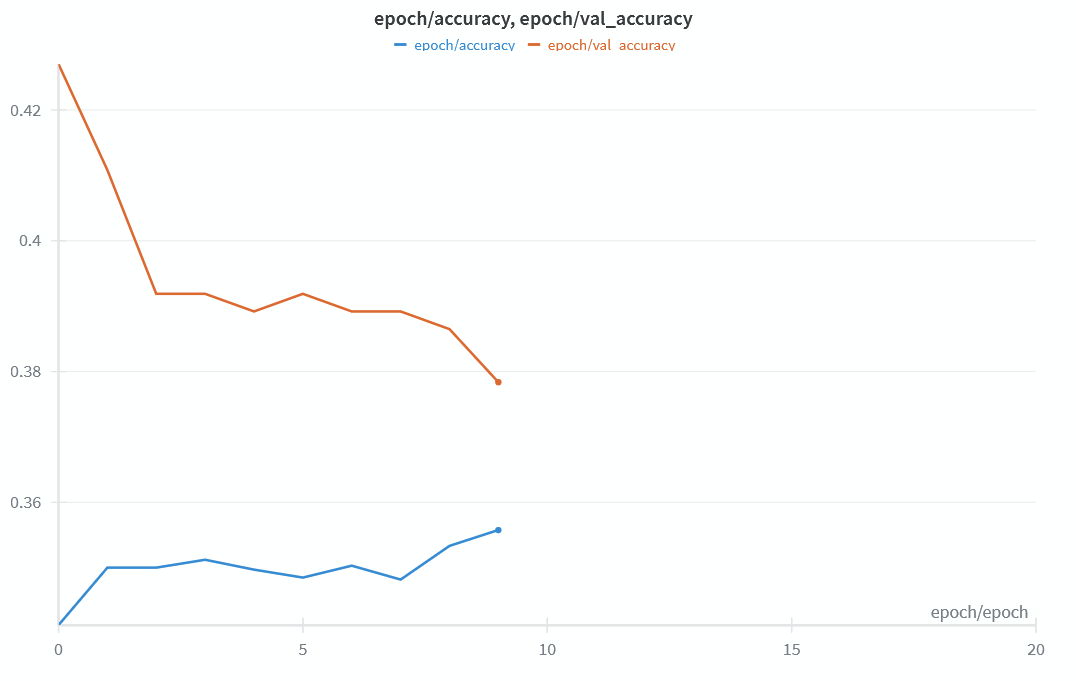

### Dropout


In [ ]:
def train():
  with wandb.init() as run:
    config = wandb.config

    IMG_H = config.img_size
    IMG_W = config.img_size
    IMG_C = 3
    CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

    def read_and_decode_image(filename, resize_dims):
      #read the raw file
      image = tf.io.read_file(filename)
      #decode image data
      image = tf.image.decode_jpeg(image, channels=IMG_C)
      #convert pixel values to float in [0,1]
      image = tf.image.convert_image_dtype(image, tf.float32)
      #resize image
      image = tf.image.resize(image, resize_dims)
      return image

    def parse_csvline(csv_line):
      # record_defaults specify the data types for each column
      record_defaults = ["", ""]
      filename, label_string = tf.io.decode_csv(csv_line, record_defaults)

      #load image
      img = read_and_decode_image(filename, [IMG_H, IMG_W])

      #convert label string to integer based on CLASS_NAMES index eg. "daisy" --> 0
      label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
      return img, label

    train_dataset = (
      tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(tf.data.AUTOTUNE)
    )

    eval_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
        .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    regularizer = keras.regularizers.l1_l2(0, 0.1)

    model = keras.Sequential([
      keras.layers.Flatten(input_shape=(IMG_H, IMG_W, IMG_C)), # entire image represented in 1D
      keras.layers.Dense(config.hidden_nodes, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(len(CLASS_NAMES),activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    logs = model.fit(
        train_dataset,
        validation_data=eval_dataset,
        epochs=config.epochs,
        callbacks=[WandbMetricsLogger(log_freq=5)]
    )



In [ ]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: 5it12hbl with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001


Epoch 1/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.2992 - loss: 1.6080 - val_accuracy: 0.4432 - val_loss: 1.3720
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.3805 - loss: 1.3945 - val_accuracy: 0.4405 - val_loss: 1.2980
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4008 - loss: 1.3350 - val_accuracy: 0.4541 - val_loss: 1.2389
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4108 - loss: 1.2974 - val_accuracy: 0.4568 - val_loss: 1.2544
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4063 - loss: 1.2975 - val_accuracy: 0.4486 - val_loss: 1.2503
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4274 - loss: 1.2829 - val_accuracy: 0.4459 - val_loss: 1.2230
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4431 - loss: 1.2535 - val_accuracy: 0.4541 - val_loss: 1.2412
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4494 - loss: 1.2566 - 

batch/accuracy,▁▁▂▂▃▄▄▅▅▆▆▆▇▅▆▆▅▅▆▆▇▆▅▆▇▇▇▇▇▆▆▇█▇▆█████
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▆▅▅▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▁▁▁▁
epoch/accuracy,▁▄▅▆▆▆▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▁▁
epoch/val_accuracy,▁▁▃▃▂▂▃▃█▇
epoch/val_loss,█▅▂▂▂▁▂▁▁▁
batch/accuracy,0.47232


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


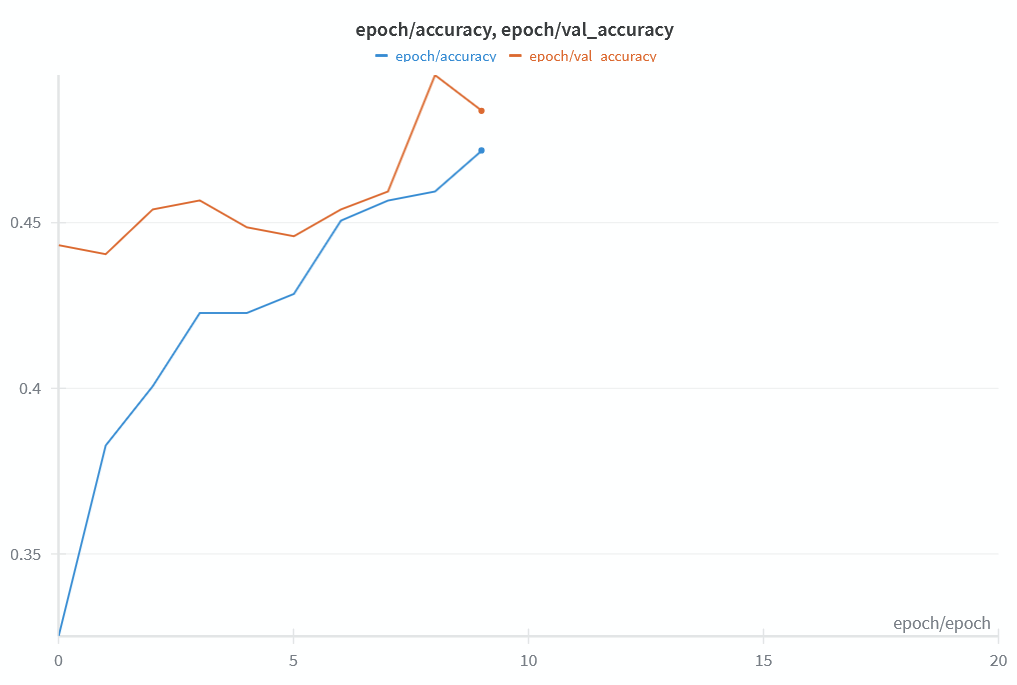

### Early stopping

In [ ]:
def train():
  with wandb.init() as run:
    config = wandb.config

    IMG_H = config.img_size
    IMG_W = config.img_size
    IMG_C = 3
    CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

    def read_and_decode_image(filename, resize_dims):
      #read the raw file
      image = tf.io.read_file(filename)
      #decode image data
      image = tf.image.decode_jpeg(image, channels=IMG_C)
      #convert pixel values to float in [0,1]
      image = tf.image.convert_image_dtype(image, tf.float32)
      #resize image
      image = tf.image.resize(image, resize_dims)
      return image

    def parse_csvline(csv_line):
      # record_defaults specify the data types for each column
      record_defaults = ["", ""]
      filename, label_string = tf.io.decode_csv(csv_line, record_defaults)

      #load image
      img = read_and_decode_image(filename, [IMG_H, IMG_W])

      #convert label string to integer based on CLASS_NAMES index eg. "daisy" --> 0
      label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
      return img, label

    train_dataset = (
      tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(tf.data.AUTOTUNE)
    )

    eval_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
        .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    regularizer = keras.regularizers.l1_l2(0, 0.1)

    model = keras.Sequential([
      keras.layers.Flatten(input_shape=(IMG_H, IMG_W, IMG_C)), # entire image represented in 1D
      keras.layers.Dense(config.hidden_nodes, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(len(CLASS_NAMES),activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    logs = model.fit(
        train_dataset,
        validation_data=eval_dataset,
        epochs=config.epochs,
        callbacks=[WandbMetricsLogger(log_freq=5),
                   keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=2, restore_best_weights=True)]
    )




In [ ]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: 4dl2icmy with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    412/Unknown 19s 44ms/step - accuracy: 0.3080 - loss: 1.5840

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.3081 - loss: 1.5836 - val_accuracy: 0.4514 - val_loss: 1.3213
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.3838 - loss: 1.3768 - val_accuracy: 0.4432 - val_loss: 1.2606
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3961 - loss: 1.3203 - val_accuracy: 0.4351 - val_loss: 1.2530
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4261 - loss: 1.2971 - val_accuracy: 0.4459 - val_loss: 1.2607
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4270 - loss: 1.2866 - val_accuracy: 0.4324 - val_loss: 1.2621


batch/accuracy,▂▂▃▃▄▄▄▄▄▄▆▅▆▆▆▆▆▆▆▆▅▆▆▆▇▇▇▁▇█████▇▇████
batch/batch_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▇▆▅▅▅▅▅▅▁▃▄▃▃▃▃▃▃▂▂▃▂▃▃▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂
epoch/accuracy,▁▅▆██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▁▁
epoch/val_accuracy,█▅▂▆▁
epoch/val_loss,█▂▁▂▂
batch/accuracy,0.434


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


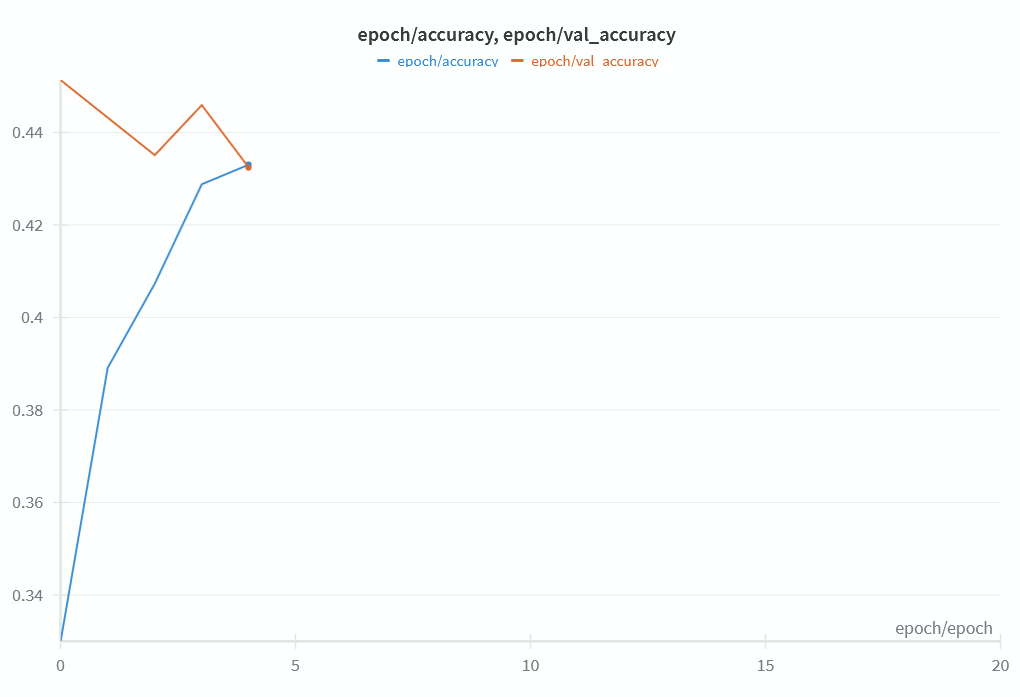

### batch normalization

In [ ]:
def train():
  with wandb.init() as run:
    config = wandb.config

    IMG_H = config.img_size
    IMG_W = config.img_size
    IMG_C = 3
    CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

    def read_and_decode_image(filename, resize_dims):
      #read the raw file
      image = tf.io.read_file(filename)
      #decode image data
      image = tf.image.decode_jpeg(image, channels=IMG_C)
      #convert pixel values to float in [0,1]
      image = tf.image.convert_image_dtype(image, tf.float32)
      #resize image
      image = tf.image.resize(image, resize_dims)
      return image

    def parse_csvline(csv_line):
      # record_defaults specify the data types for each column
      record_defaults = ["", ""]
      filename, label_string = tf.io.decode_csv(csv_line, record_defaults)

      #load image
      img = read_and_decode_image(filename, [IMG_H, IMG_W])

      #convert label string to integer based on CLASS_NAMES index eg. "daisy" --> 0
      label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
      return img, label

    train_dataset = (
      tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(tf.data.AUTOTUNE)
    )

    eval_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
        .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    regularizer = keras.regularizers.l1_l2(0, 0.1)

    model = keras.Sequential([
      keras.layers.Flatten(input_shape=(IMG_H, IMG_W, IMG_C)), # entire image represented in 1D

      keras.layers.Dense(config.hidden_nodes),
      keras.layers.BatchNormalization(),
      keras.layers.Activation('relu'),

      keras.layers.Dense(len(CLASS_NAMES)),
      keras.layers.BatchNormalization(),
      keras.layers.Activation('softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    logs = model.fit(
        train_dataset,
        validation_data=eval_dataset,
        epochs=config.epochs,
        callbacks=[WandbMetricsLogger(log_freq=5)]
    )



In [ ]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: xzbyia9t with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    412/Unknown 19s 43ms/step - accuracy: 0.3780 - loss: 1.4564

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.3781 - loss: 1.4560 - val_accuracy: 0.4541 - val_loss: 1.3132
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.5243 - loss: 1.1829 - val_accuracy: 0.4378 - val_loss: 1.3672
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.5773 - loss: 1.0630 - val_accuracy: 0.4595 - val_loss: 1.3870
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.6442 - loss: 0.9421 - val_accuracy: 0.4297 - val_loss: 1.5178
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.7297 - loss: 0.8123 - val_accuracy: 0.4108 - val_loss: 1.7332
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.7882 - loss: 0.6883 - val_accuracy: 0.4189 - val_loss: 1.8598
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.8290 - loss: 0.5901 - val_accuracy: 0.4243 - val_loss: 1.8961
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.8556 - loss: 0.5137 - val_accurac

batch/accuracy,▁▂▂▂▂▂▂▄▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▇▆▆▇▇▇▇▇█▇█████
batch/batch_step,▁▁▁▁▁▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
epoch/accuracy,▁▃▄▅▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▂▂▁▁
epoch/val_accuracy,▇▆█▅▃▄▄▃▁▂
epoch/val_loss,▁▁▂▃▄▅▅▅█▅
batch/accuracy,0.90785


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


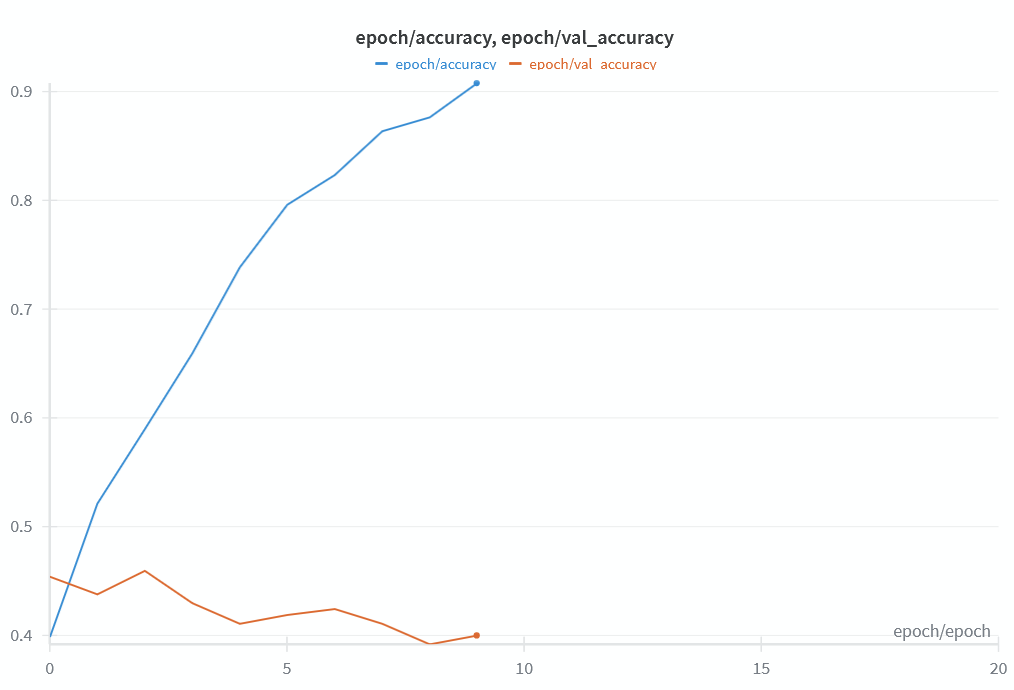

### All 4 together

In [18]:
def train():
  with wandb.init() as run:
    config = wandb.config

    IMG_H = config.img_size
    IMG_W = config.img_size
    IMG_C = 3
    CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

    def read_and_decode_image(filename, resize_dims):
      #read the raw file
      image = tf.io.read_file(filename)
      #decode image data
      image = tf.image.decode_jpeg(image, channels=IMG_C)
      #convert pixel values to float in [0,1]
      image = tf.image.convert_image_dtype(image, tf.float32)
      #resize image
      image = tf.image.resize(image, resize_dims)
      return image

    def parse_csvline(csv_line):
      # record_defaults specify the data types for each column
      record_defaults = ["", ""]
      filename, label_string = tf.io.decode_csv(csv_line, record_defaults)

      #load image
      img = read_and_decode_image(filename, [IMG_H, IMG_W])

      #convert label string to integer based on CLASS_NAMES index eg. "daisy" --> 0
      label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
      return img, label

    train_dataset = (
      tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(tf.data.AUTOTUNE)
    )

    eval_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
        .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    regularizer = keras.regularizers.l1_l2(0, 0.1)

    model = keras.Sequential([
      keras.layers.Flatten(input_shape=(IMG_H, IMG_W, IMG_C)),

      keras.layers.Dense(config.hidden_nodes, kernel_regularizer=regularizer),  #regularization
      keras.layers.BatchNormalization(),  #batch normalization
      keras.layers.Activation('relu'),
      keras.layers.Dropout(0.5),  #dropout

      keras.layers.Dense(len(CLASS_NAMES),  kernel_regularizer=regularizer),
      keras.layers.BatchNormalization(),
      keras.layers.Activation('softmax')
    ])

    model.compile(
            optimizer='adam',
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'],
        )

    logs = model.fit(
        train_dataset,
        validation_data=eval_dataset,
        epochs=config.epochs,
        callbacks=[WandbMetricsLogger(log_freq=5),
                    keras.callbacks.EarlyStopping(monitor='val_loss',   #early stopping
                                                  patience=2, restore_best_weights=True)]
    )


In [19]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: 9bj7m204 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001
wandb: Currently logged in as: muskaan-maurya06 (muskaan-maurya06-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    412/Unknown 23s 51ms/step - accuracy: 0.3248 - loss: 10.4252

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.3249 - loss: 10.4008 - val_accuracy: 0.3811 - val_loss: 2.0204
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.3741 - loss: 1.9138 - val_accuracy: 0.4189 - val_loss: 1.8638
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.3815 - loss: 1.8525 - val_accuracy: 0.3459 - val_loss: 2.0701
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.4004 - loss: 1.8928 - val_accuracy: 0.3676 - val_loss: 1.8296
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.3878 - loss: 1.7704 - val_accuracy: 0.3216 - val_loss: 1.8752
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.3924 - loss: 1.7794 - val_accuracy: 0.3378 - val_loss: 1.9037


batch/accuracy,▁▁▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▆▅▅█▆▅▅▅▅▅▅▅▅▅▅
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆▆█▇▇
epoch/epoch,▁▂▄▅▇█
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁
epoch/val_accuracy,▅█▃▄▁▂
epoch/val_loss,▇▂█▁▂▃
batch/accuracy,0.38686


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


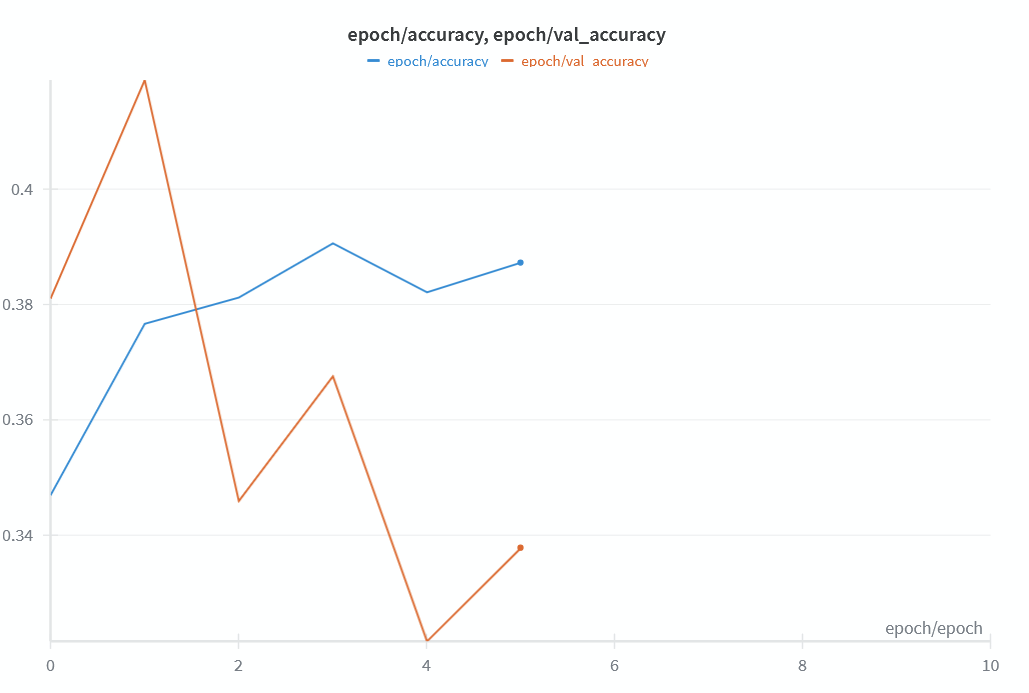